# Task 1:
Developing a multi-layer neural network for classification using numpy.
### Features
- Sigmoid, ReLU and Softmax Layers with forward and backward pass
- Inverted dropout
- Fully parametrizable neural network class
- Two optimizers (SGD & SGD with momentum)

In [105]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Importing libraries
We will be using the CIFAR-10 dataset from Keras.

In [106]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [107]:
# Setting a fixed seed for reproducibility
SEED = 17
np.random.seed(SEED)

In [108]:
# Fetch CIFAR-10 data and split into train/test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split training data into training and validation sets (10% for validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Flatten data
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1).astype(np.float32) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32) / 255.0

# Print data shapes
print(f"Train Images Shape: {X_train_flat.shape}, Train Labels Shape: {y_train.shape}")
print(f"Validation Images Shape: {X_valid_flat.shape}, Validation Labels Shape: {y_valid.shape}")
print(f"Test Images Shape: {X_test_flat.shape}, Test Labels Shape: {y_test.shape}")

Train Images Shape:       (45000, 3072)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 3072)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 3072)
Test Labels Shape:        (10000, 1)


The data has been correctly split from 50,000 32x32 images to 45,000 training images and 5,000 validation images. 10,000 images for testing have also been correctly imported.

## Visualising the dataset

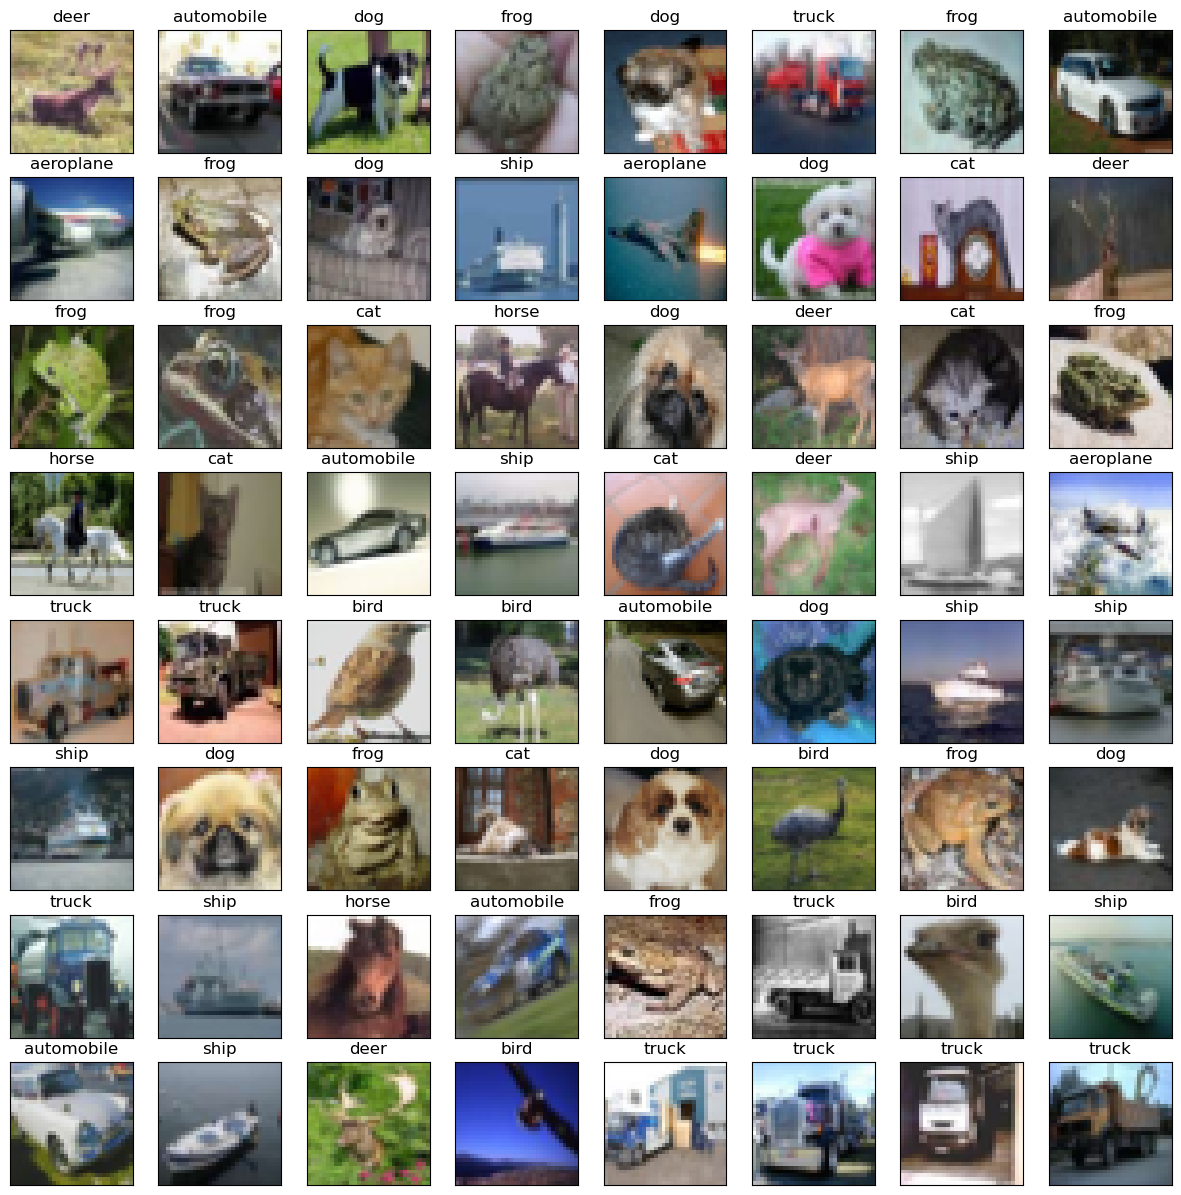

In [109]:
# CIFAR-10 classes
class_names = ["aeroplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Create a new figure
plt.figure(figsize=(15, 15))

# Loop over the first 64 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Reshape the flattened image back to (32, 32, 3) if necessary
    img = X_train[i].reshape(32, 32, 3) if X_train[i].shape == (3072,) else X_train[i]
    
    # Display the image
    plt.imshow(img)

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

## Implementing the Neural Network
We built a fully connected neural network with customizable layers to evaluate its performance on CIFAR-10 for 10-class classification. The network includes ReLU, Sigmoid, and Softmax activations, dropout for regularization, and is trained using gradient descent with a learning rate of 0.01. The model architecture consists of 10 input nodes, two hidden layers with 16 and 8 nodes, and 10 output nodes. Training was performed over 100 epochs with a batch size of 32, and both training and validation loss were tracked.

In [110]:
# Activation functions
class ActivationFunctions:
    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(float)

# Layer class
class Layer:
    def __init__(self, nodes_of_prev, nodes, activation):
        self.nodes = nodes
        self.activation = activation
        self.weights = np.random.randn(nodes_of_prev, nodes) * np.sqrt(2.0 / nodes_of_prev)
        self.biases = np.zeros((1, nodes))

    def forward(self, input_data):
        self.z = np.dot(input_data, self.weights) + self.biases
        if self.activation == "sigmoid":
            self.a = ActivationFunctions.sigmoid(self.z)
        elif self.activation == "relu":
            self.a = ActivationFunctions.relu(self.z)
        elif self.activation == "softmax":
            self.a = ActivationFunctions.softmax(self.z)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")
        return self.a

    def backward(self, da, input_data):
        m = input_data.shape[0]
        if self.activation == "sigmoid":
            dz = da * ActivationFunctions.sigmoid_derivative(self.a)
        elif self.activation == "relu":
            dz = da * ActivationFunctions.relu_derivative(self.a)
        else:
            dz = da

        dw = np.dot(input_data.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        da_prev = np.dot(dz, self.weights.T)

        return dw, db, da_prev

# Neural Network class
class NeuralNetwork:
    def __init__(self, layers_config, learning_rate=0.01):
        self.layers = []
        self.learning_rate = learning_rate
        for i in range(len(layers_config) - 1):
            self.layers.append(Layer(layers_config[i], layers_config[i + 1], activation="relu" if i < len(layers_config) - 2 else "softmax"))

    def forward(self, X):
        self.a_cache = [X]
        for layer in self.layers:
            X = layer.forward(X)
            self.a_cache.append(X)
        return X

    def backward(self, X, Y):
        da = self.a_cache[-1] - Y
        grads = []

        for i in reversed(range(len(self.layers))):
            input_data = self.a_cache[i]
            dw, db, da = self.layers[i].backward(da, input_data)
            grads.insert(0, (dw, db))

        return grads

    def update_params(self, grads):
        for i, (dw, db) in enumerate(grads):
            self.layers[i].weights -= self.learning_rate * dw
            self.layers[i].biases -= self.learning_rate * db

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=20, batch_size=64):
        train_loss = []
        val_loss = []
        train_accuracy = []
        m = X_train.shape[0]

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_acc = 0
            indices = np.random.permutation(m)
            X_train, Y_train = X_train[indices], Y_train[indices]

            for i in range(0, m, batch_size):
                X_batch = X_train[i:i + batch_size]
                Y_batch = Y_train[i:i + batch_size]

                Y_pred = self.forward(X_batch)
                loss = -np.sum(Y_batch * np.log(Y_pred + 1e-8)) / batch_size
                accuracy = np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_batch, axis=1))

                epoch_loss += loss
                epoch_acc += accuracy

                grads = self.backward(X_batch, Y_batch)
                self.update_params(grads)

            train_loss.append(epoch_loss / ((m + batch_size - 1) // batch_size))
            val_loss_epoch = -np.sum(Y_valid * np.log(self.forward(X_valid) + 1e-8)) / Y_valid.shape[0]
            val_loss.append(val_loss_epoch)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {epoch_acc / ((m + batch_size - 1) // batch_size):.4f}")
            train_accuracy.append(epoch_acc / ((m + batch_size - 1) // batch_size))

        return train_loss, train_accuracy, val_loss

    def plot_loss(self, train_loss, val_loss=None):
        plt.figure(figsize=(8, 5))
        plt.plot(train_loss, label="Training Loss")
        if val_loss:
            plt.plot(val_loss, label="Validation Loss", linestyle="--")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracy(self, train_accuracy):
        plt.figure(figsize=(8, 5))
        plt.plot(train_accuracy, label="Training Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

# One-hot encode labels
y_train = np.eye(10)[y_train.flatten().astype(int)]
y_valid = np.eye(10)[y_valid.flatten().astype(int)]
y_test = np.eye(10)[y_test.flatten().astype(int)]

# Define parameters
input_size = 32 * 32 * 3
output_size = 10
epochs = 20
learning_rate = 0.1

# Train neural network
nn = NeuralNetwork([input_size, 128, output_size], learning_rate=learning_rate)
train_loss, train_accuracy, val_loss = nn.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

# Plot results
nn.plot_loss(train_loss)
nn.plot_accuracy(train_accuracy)

Epoch 1/20, Loss: 2.0430, Accuracy: 0.2475
Epoch 2/20, Loss: 1.8617, Accuracy: 0.3212
Epoch 3/20, Loss: 1.7988, Accuracy: 0.3462
Epoch 4/20, Loss: 1.7469, Accuracy: 0.3678
Epoch 5/20, Loss: 1.7208, Accuracy: 0.3792
Epoch 6/20, Loss: 1.6904, Accuracy: 0.3951
Epoch 7/20, Loss: 1.6609, Accuracy: 0.4062
Epoch 8/20, Loss: 1.6401, Accuracy: 0.4139
Epoch 9/20, Loss: 1.6244, Accuracy: 0.4174
Epoch 10/20, Loss: 1.6175, Accuracy: 0.4209
Epoch 11/20, Loss: 1.6016, Accuracy: 0.4300
Epoch 12/20, Loss: 1.5930, Accuracy: 0.4310
Epoch 13/20, Loss: 1.5729, Accuracy: 0.4376
Epoch 14/20, Loss: 1.5637, Accuracy: 0.4415
Epoch 15/20, Loss: 1.5542, Accuracy: 0.4433
Epoch 16/20, Loss: 1.5422, Accuracy: 0.4502
Epoch 17/20, Loss: 1.5281, Accuracy: 0.4555
Epoch 18/20, Loss: 1.5210, Accuracy: 0.4568
Epoch 19/20, Loss: 1.5106, Accuracy: 0.4617
Epoch 20/20, Loss: 1.4953, Accuracy: 0.4672


By default, the neural network will use the configuration of 128 nodes and ReLU activation, with the output layer being Softmax.

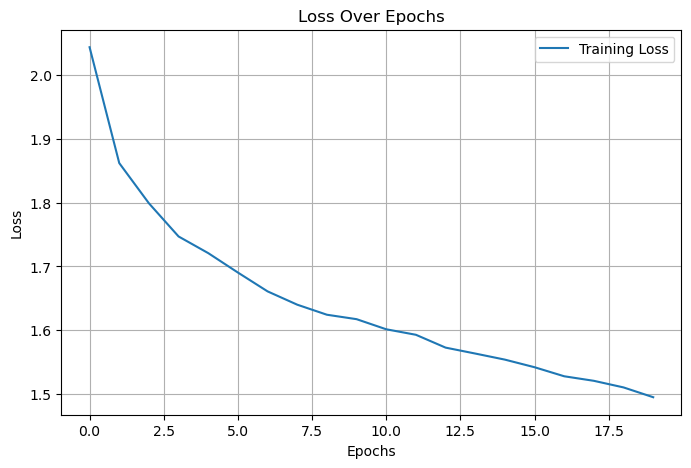

In [115]:
nn.plot_loss(train_loss)

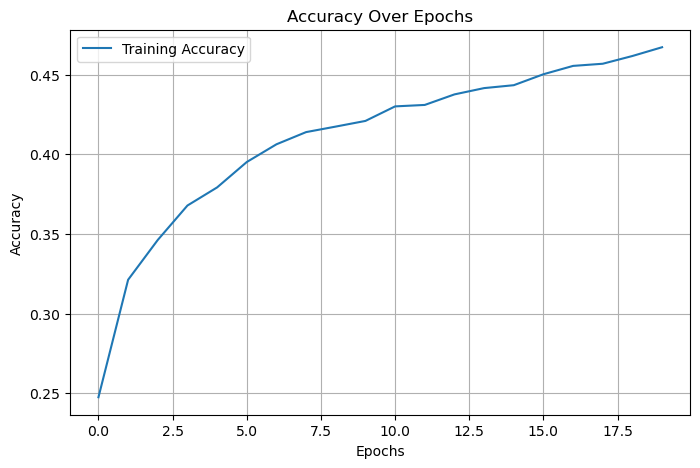

In [112]:
nn.plot_accuracy(train_accuracy)

## 2 Sigmoid, 1 ReLU

Epoch 1/20, Loss: 2.3068, Accuracy: 0.1418
Epoch 2/20, Loss: 2.2293, Accuracy: 0.1973
Epoch 3/20, Loss: 2.1692, Accuracy: 0.2302
Epoch 4/20, Loss: 2.1163, Accuracy: 0.2488
Epoch 5/20, Loss: 2.0748, Accuracy: 0.2663
Epoch 6/20, Loss: 2.0400, Accuracy: 0.2765
Epoch 7/20, Loss: 2.0090, Accuracy: 0.2888
Epoch 8/20, Loss: 1.9813, Accuracy: 0.2975
Epoch 9/20, Loss: 1.9561, Accuracy: 0.3051
Epoch 10/20, Loss: 1.9342, Accuracy: 0.3147
Epoch 11/20, Loss: 1.9151, Accuracy: 0.3215
Epoch 12/20, Loss: 1.8992, Accuracy: 0.3296
Epoch 13/20, Loss: 1.8854, Accuracy: 0.3329
Epoch 14/20, Loss: 1.8734, Accuracy: 0.3388
Epoch 15/20, Loss: 1.8625, Accuracy: 0.3420
Epoch 16/20, Loss: 1.8527, Accuracy: 0.3450
Epoch 17/20, Loss: 1.8429, Accuracy: 0.3489
Epoch 18/20, Loss: 1.8341, Accuracy: 0.3518
Epoch 19/20, Loss: 1.8252, Accuracy: 0.3548
Epoch 20/20, Loss: 1.8165, Accuracy: 0.3568


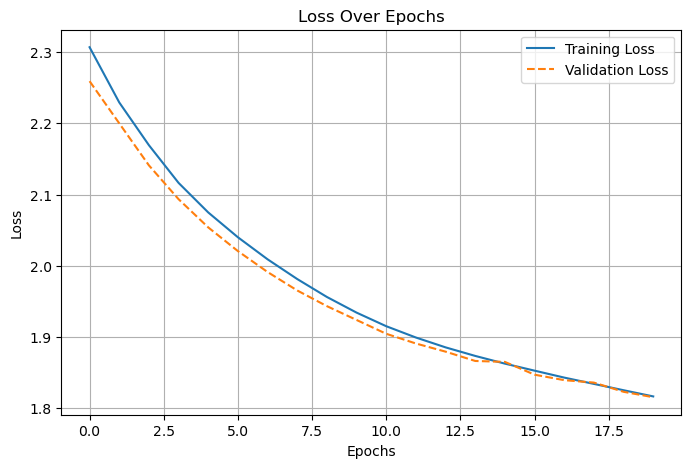

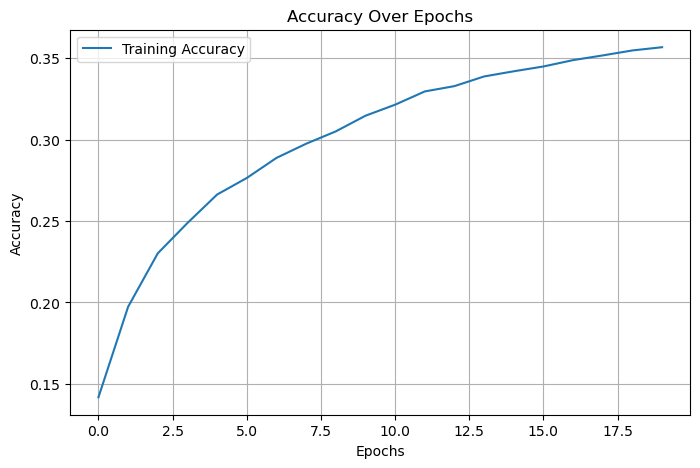

In [113]:
nn_variant = neuralNetwork(
    layers_config=[input_size, 150, 100, 50, output_size],
    learning_rate=0.005
)

# Set custom activations for each layer
nn_variant.layers[0].activation = "sigmoid"   # First hidden layer uses Sigmoid
nn_variant.layers[1].activation = "relu"     # Second hidden layer uses ReLU
nn_variant.layers[2].activation = "sigmoid"  # Third hidden layer uses Sigmoid
nn_variant.layers[-1].activation = "softmax" # Output layer uses Softmax

# Training
variant_loss, variant_accuracy, variant_val_loss = nn_variant.train(
    X_train=X_train_flat, Y_train=y_train, X_valid=X_valid_flat, Y_valid=y_valid, epochs=epochs, batch_size=64
)

# Plot the loss graph
nn_variant.plot_loss(variant_loss, variant_val_loss)

# Plot the accuracy graph
nn_variant.plot_accuracy(variant_accuracy)

# DOESN'T WORK ATM 3 Sigmoid layers and SGD with momentum

In [92]:
nn_variant_sgd_momentum = neuralNetwork(
    layers_config=[input_size, 128, 64, 32, output_size],  # 3 hidden layers
    learning_rate=0.005,
    optimizer=SGDmomentumOptimizer(momentum=0.9)  # Use SGD with momentum
)

# Set custom activations for each layer
nn_variant_sgd_momentum.layers[0].activation = "sigmoid"  # First hidden layer uses Sigmoid
nn_variant_sgd_momentum.layers[1].activation = "sigmoid"  # Second hidden layer uses Sigmoid
nn_variant_sgd_momentum.layers[2].activation = "sigmoid"  # Third hidden layer uses Sigmoid
nn_variant_sgd_momentum.layers[-1].activation = "softmax"  # Output layer uses Softmax

# Train the new network
variant_loss, variant_accuracy, variant_val_loss = nn_variant_sgd_momentum.train(
    X_train=X_train_flat, Y_train=y_train, X_valid=X_valid_flat, Y_valid=y_valid, epochs=epochs, batch_size=64
)

# Plot the loss graph for the new network
nn_variant_sgd_momentum.plot_loss(variant_loss, variant_val_loss)

# Plot the accuracy graph for the new network
nn_variant_sgd_momentum.plot_accuracy(variant_accuracy)

TypeError: SGDmomentumOptimizer() missing 5 required positional arguments: 'weights', 'biases', 'gradients', 'velocities', and 'learning_rate'

We have built the softmax function so it calculates probabilities for each class by exponentiating the input values, normalizing them for stability. The cross_entropy_loss measures how well the predicted probabilities match the true labels, with safeguards to avoid math errors. Weights and biases are initialized with scaled random values (for weights) and zeros (for biases). During the softmax_forward_backward function, the forward pass computes the class probabilities and loss, while the backward pass calculates gradients for weights and biases. These are then updated using gradient descent to optimize the model.

Next we have implemented training through the use of the sigmoid activation function.
Weights are initialized with random values scaled by the input size, and biases are set to zero. During the forward pass, the model computes a weighted sum of inputs, applies softmax for probabilities, and calculates cross-entropy loss. The backward pass computes gradients for weights and biases, which are updated using gradient descent.

The train function processes the data in mini-batches, performing forward and backward passes for each batch. The loss is averaged per epoch and tracked. Images are preprocessed by flattening and normalizing pixel values, while labels are one-hot encoded.

Finally, the model is trained, and the loss over epochs is plotted to show learning progress.


Our next task was to define the ReLU activation function. 
ReLU Activation: The function turns any negative input into zero, and leaves positive values unchanged. It's a common way to introduce non-linearity in models.

ReLU Derivative: This tells us how to adjust weights during backpropagation. If the input is positive, the derivative is 1, otherwise it's 0.

Weight and Bias Initialization: The weights are small random values, and biases are set to zero at the start. This helps the model begin training.

Forward and Backward Pass:

In the forward pass, the input data is passed through the model, transformed by the weights and biases, and then activated by ReLU.
The loss is calculated to measure how far the model’s predictions are from the actual values.
In the backward pass, we compute the gradients of the loss with respect to weights and biases, and then update them to reduce the error.
Training Loop: Over several iterations (epochs), the model keeps adjusting the weights and biases to minimize the error, using the forward and backward passes.


Our implementation here compares Stochastic Gradient Descent (SGD) and SGD with Momentum for training a neural network. SGD updates weights directly based on gradients, while Momentum adds a "velocity" term to speed up updates and reduce oscillations, leading to faster convergence. Weights are initialized using Xavier initialization, and biases are set to zero. The data is preprocessed by flattening images, normalizing them, and one-hot encoding the labels. Training is done in mini-batches, using softmax for predictions and cross-entropy loss.

# Old code DNU


Training with SGD Optimizer:
Epoch 1/20, Loss: 2.3378
Epoch 2/20, Loss: 2.3374
Epoch 3/20, Loss: 2.3371
Epoch 4/20, Loss: 2.3367
Epoch 5/20, Loss: 2.3363
Epoch 6/20, Loss: 2.3360
Epoch 7/20, Loss: 2.3356
Epoch 8/20, Loss: 2.3353
Epoch 9/20, Loss: 2.3349
Epoch 10/20, Loss: 2.3346
Epoch 11/20, Loss: 2.3342
Epoch 12/20, Loss: 2.3338
Epoch 13/20, Loss: 2.3335
Epoch 14/20, Loss: 2.3331
Epoch 15/20, Loss: 2.3328
Epoch 16/20, Loss: 2.3324
Epoch 17/20, Loss: 2.3321
Epoch 18/20, Loss: 2.3317
Epoch 19/20, Loss: 2.3314
Epoch 20/20, Loss: 2.3310

Training with SGD Momentum Optimizer:
Epoch 1/20, Loss: 2.5848
Epoch 2/20, Loss: 2.5868
Epoch 3/20, Loss: 2.5828
Epoch 4/20, Loss: 2.5789
Epoch 5/20, Loss: 2.5751
Epoch 6/20, Loss: 2.5713
Epoch 7/20, Loss: 2.5676
Epoch 8/20, Loss: 2.5639
Epoch 9/20, Loss: 2.5602
Epoch 10/20, Loss: 2.5566
Epoch 11/20, Loss: 2.5530
Epoch 12/20, Loss: 2.5495
Epoch 13/20, Loss: 2.5461
Epoch 14/20, Loss: 2.5427
Epoch 15/20, Loss: 2.5393
Epoch 16/20, Loss: 2.5359
Epoch 17/20, 

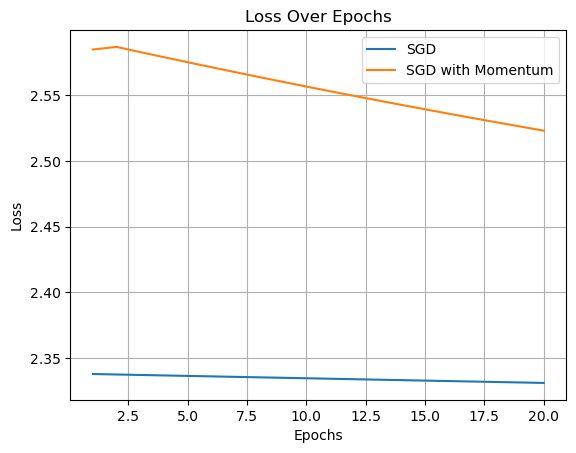

In [13]:
# Implementing the SGD optimizer
def SGDoptimizer(weights, biases, gradients, learning_rate):
    d_weights, d_biases = gradients

    # Update weights and biases using the SGD formula
    weights -= learning_rate * d_weights
    biases -= learning_rate * d_biases

    return weights, biases

# Implementing the SGD with Momentum optimizer
def SGDmomentumOptimizer(weights, biases, gradients, velocities, learning_rate, momentum=0.9):
    d_weights, d_biases = gradients
    v_weights, v_biases = velocities

    # Update velocities based on gradients and momentum
    v_weights = momentum * v_weights - learning_rate * d_weights
    v_biases = momentum * v_biases - learning_rate * d_biases

    # Update weights and biases using the velocities
    weights += v_weights
    biases += v_biases

    return weights, biases, (v_weights, v_biases)

# Initialize weights and biases
def initialize_weights(input_size, output_size):
    weights = np.random.randn(input_size, output_size) * np.sqrt(1.0 / input_size) # Xavier initialization
    biases = np.zeros((1, output_size))
    return weights, biases

# Training with selected optimizer
def train_with_optimizer(
    x_train, y_train, input_size, output_size, epochs=10, learning_rate=0.1,
    optimizer="SGDoptimizer", momentum=0.9, batch_size=64
):
    # Initialize weights and biases
    weights, biases = initialize_weights(input_size, output_size)

    # Initialize velocities for SGD with momentum
    velocities = (np.zeros_like(weights), np.zeros_like(biases))

    # Store losses for each epoch
    epoch_losses = []

    num_batches = x_train.shape[0] // batch_size 

    for epoch in range(epochs):
        epoch_loss = 0 

        for i in range(num_batches):
            # Create mini-batches
            start = i * batch_size
            end = start + batch_size
            x_batch = x_train[start:end]
            y_batch = y_train[start:end]

            # Forward pass using softmax
            z = np.dot(x_batch, weights) + biases
            a = softmax(z)

            # Cross-entropy loss
            loss = -np.mean(np.sum(y_batch * np.log(a + 1e-15), axis=1))
            epoch_loss += loss

            # Backward pass
            d_weights = np.dot(x_batch.T, (a - y_batch))
            d_biases = np.sum(a - y_batch, axis=0, keepdims=True)

            # Update weights and biases using the selected optimizer
            if optimizer == "SGDoptimizer":
                weights, biases = SGDoptimizer(weights, biases, (d_weights, d_biases), learning_rate)
            elif optimizer == "SGDmomentumOptimizer":
                weights, biases, velocities = SGDmomentumOptimizer(
                    weights, biases, (d_weights, d_biases), velocities,
                    learning_rate, momentum
                )
            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

        # Record and print the average loss for the epoch
        epoch_loss /= num_batches
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return weights, biases, epoch_losses


X_train = np.random.rand(45000, 32, 32, 3) 
y_train = np.random.randint(0, 10, size=(45000,))  

# Preprocess data: Flatten and normalize - Ask if necessary with teammates
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0 

# One-hot encode labels - Ask if necessary with teammates
y_train = np.eye(10)[y_train.flatten().astype(int)] 

# Set hyperparameters
input_size = 32 * 32 * 3 
output_size = 10
epochs = 20
learning_rate = 0.1
momentum = 0.9

# Training with SGD Optimizer
print("\nTraining with SGD Optimizer:")
_, _, losses_sgd = train_with_optimizer(
    x_train=X_train, y_train=y_train, 
    input_size=input_size, output_size=output_size, 
    epochs=epochs, learning_rate=learning_rate, 
    optimizer="SGDoptimizer", batch_size=64
)

# Training with SGD Momentum Optimizer
print("\nTraining with SGD Momentum Optimizer:")
_, _, losses_momentum = train_with_optimizer(
    x_train=X_train, y_train=y_train, 
    input_size=input_size, output_size=output_size, 
    epochs=epochs, learning_rate=learning_rate, 
    optimizer="SGDmomentumOptimizer", momentum=momentum, batch_size=64
)

# Plot the loss graph
plt.plot(range(1, epochs + 1), losses_sgd, label="SGD")
plt.plot(range(1, epochs + 1), losses_momentum, label="SGD with Momentum")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Sources
- Loading in the CIFAR-10 Dataset:
  https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn/notebook
  Details on how to load the dataset and ability to see the set of images.
- Deep Neural net with forward and back propagation:
  https://www.geeksforgeeks.org/deep-neural-net-with-forward-and-back-propagation-from-scratch-python/
  Used to understand what forward and backward propagation is and basics of a NN.
  No code was taken.